In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest

# Metrics
from sklearn.metrics import precision_score, recall_score, make_scorer

# Kaggle config.
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/creditcardfraud/creditcard.csv


### Importing the dataset
- Only the first `80,000` rows

In [2]:
file_path = '/kaggle/input/creditcardfraud/creditcard.csv'
df = pd.read_csv(file_path)[:80000]

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Preprocessing

### Features
- Extracting the **features** into `X` and **classes** into `y`

In [3]:
X = df.drop(columns=['Time', 'Amount', 'Class']).values
y = df['Class'].values

X

array([[-1.35980713, -0.07278117,  2.53634674, ..., -0.18911484,
         0.13355838, -0.02105305],
       [ 1.19185711,  0.26615071,  0.16648011, ...,  0.12589453,
        -0.0089831 ,  0.01472417],
       [-1.35835406, -1.34016307,  1.77320934, ..., -0.13909657,
        -0.05535279, -0.05975184],
       ...,
       [-2.28727012,  1.12156794,  1.16358497, ..., -0.2520452 ,
        -0.40904438, -0.25311435],
       [-1.3509413 ,  0.23341085,  0.95082419, ..., -0.27339173,
         0.35042154,  0.14085102],
       [-2.00700424,  0.73613717,  0.05184662, ..., -0.96230381,
        -0.95055099, -0.59174836]])

### Target labels
- `1` denotes the **fraud** cases
- `0` denotes the **genuine** cases

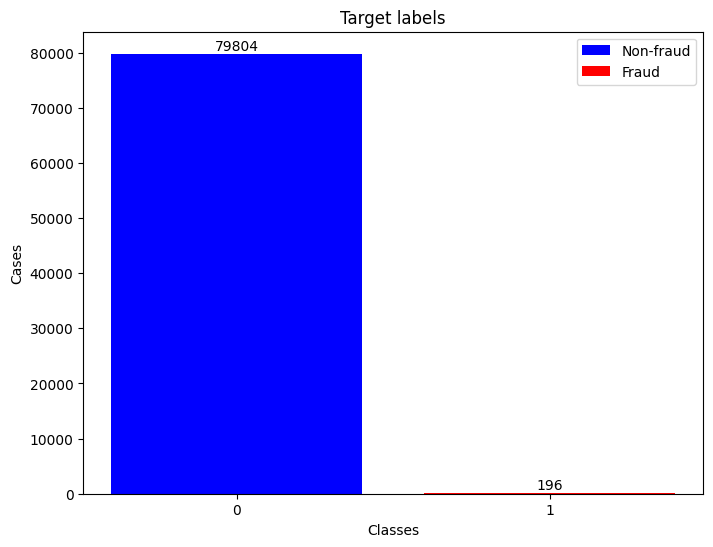

In [4]:
classes, classes_count = np.unique(df['Class'].values, return_counts=True)

plt.figure(figsize=(8, 6))
bars = plt.bar(classes, classes_count, color=['blue', 'red'])

for bar, count in zip(bars, classes_count):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 20, count,
             ha='center', va='bottom', color='black')

plt.title("Target labels")
plt.xticks(classes)

plt.xlabel("Classes")
plt.ylabel("Cases")
plt.legend(bars, ["Non-fraud", "Fraud"])

plt.show()

## Modelling

### Logistic Regression
- Using `LogisticRegression` for **binary classification**

In [5]:
model = LogisticRegression(class_weight={0: 1, 1: 2}, max_iter=1000)

pred1 = model.fit(X, y).predict(X).sum()

print(f"Predicted number of Fraud cases : {pred1}")

Predicted number of Fraud cases : 171


### **Grid Search**
- Using `GridSearchCV` to determine the optimal **class weights**
- `4-fold` **Cross-Validation** is being used

In [6]:
grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={'class_weight': [{0: 1, 1: v} for v in range(1, 4)]},
    cv=4,
    n_jobs=-1)

grid

GridSearchCV(cv=4, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 3}]})

#### Training the `grid`

In [7]:
grid.fit(X, y)

GridSearchCV(cv=4, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 3}]})

#### Results of the `cross-validation`
- Finding out the optimal **class weights**

In [8]:
cv_results = pd.DataFrame(grid.cv_results_)

cv_results.sort_values(by='mean_test_score', ascending=False).head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.928524,0.213966,0.004648,0.0003,"{0: 1, 1: 1}","{'class_weight': {0: 1, 1: 1}}",0.99405,0.99835,0.99945,0.9978,0.997413,0.00203,1


## Metrics

### Precision and Recall
- Using different scoring metrics

In [9]:
p_score = precision_score(y, grid.predict(X))
r_score = recall_score(y, grid.predict(X))

print(f"Precision Score : {p_score}\nRecall Score    : {r_score}")

Precision Score : 0.7682119205298014
Recall Score    : 0.5918367346938775


#### Adding `precision` and `recall` to the **Grid Search**
- Optimizing over the `precision` score

In [10]:
grid_pr = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={'class_weight': [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]},
    scoring={"precision": make_scorer(precision_score), "recall_score": make_scorer(recall_score)},
    refit='precision',
    return_train_score=True,
    cv=10,
    n_jobs=-1)

grid_pr

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1.0},
                                          {0: 1, 1: 1.6551724137931034},
                                          {0: 1, 1: 2.310344827586207},
                                          {0: 1, 1: 2.9655172413793105},
                                          {0: 1, 1: 3.6206896551724137},
                                          {0: 1, 1: 4.275862068965517},
                                          {0: 1, 1: 4.931034482758621},
                                          {0: 1, 1: 5.586206896551724},
                                          {0: 1, 1: 6.241379310344827},
                                          {0: 1, 1: 6.896551724137931},...
                                          {0: 1, 1: 14.758620689655173},
                                          {0: 1, 1: 15.413793103448276},
                                          {0: 1, 1: 16.06896551724138},
                                          {0: 1, 1: 16.724137931034484},
                                          {0: 1, 1: 17.379310344827587},
                                          {0: 1, 1: 18.03448275862069},
                                          {0: 1, 1: 18.689655172413794},
                                          {0: 1, 1: 19.344827586206897},
                                          {0: 1, 1: 20.0}]},
             refit='precision', return_train_score=True,
             scoring={'precision': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)})

#### Training the `grid_pr`

In [12]:
grid_pr.fit(X, y)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1.0},
                                          {0: 1, 1: 1.6551724137931034},
                                          {0: 1, 1: 2.310344827586207},
                                          {0: 1, 1: 2.9655172413793105},
                                          {0: 1, 1: 3.6206896551724137},
                                          {0: 1, 1: 4.275862068965517},
                                          {0: 1, 1: 4.931034482758621},
                                          {0: 1, 1: 5.586206896551724},
                                          {0: 1, 1: 6.241379310344827},
                                          {0: 1, 1: 6.896551724137931},...
                                          {0: 1, 1: 14.758620689655173},
                                          {0: 1, 1: 15.413793103448276},
                                          {0: 1, 1: 16.06896551724138},
                                          {0: 1, 1: 16.724137931034484},
                                          {0: 1, 1: 17.379310344827587},
                                          {0: 1, 1: 18.03448275862069},
                                          {0: 1, 1: 18.689655172413794},
                                          {0: 1, 1: 19.344827586206897},
                                          {0: 1, 1: 20.0}]},
             refit='precision', return_train_score=True,
             scoring={'precision': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)})

#### Results of the `cross-validation`
- Finding out the optimal **class weights** based on `precision` score

In [14]:
cv_results_pr = pd.DataFrame(grid_pr.cv_results_)

cv_results_pr.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,...,split2_train_recall_score,split3_train_recall_score,split4_train_recall_score,split5_train_recall_score,split6_train_recall_score,split7_train_recall_score,split8_train_recall_score,split9_train_recall_score,mean_train_recall_score,std_train_recall_score
0,1.125695,0.118743,0.012610,0.002093,"{0: 1, 1: 1.0}","{'class_weight': {0: 1, 1: 1.0}}",1.0,0.463415,0.583333,1.0,...,0.627119,0.548023,0.573864,0.573864,0.562500,0.613636,0.636364,0.607955,0.612185,0.054733
1,1.152776,0.125908,0.013539,0.005764,"{0: 1, 1: 1.6551724137931034}","{'class_weight': {0: 1, 1: 1.6551724137931034}}",1.0,0.463415,0.583333,1.0,...,0.683616,0.627119,0.670455,0.647727,0.630682,0.687500,0.698864,0.687500,0.680239,0.050286
2,1.162918,0.207262,0.013805,0.004188,"{0: 1, 1: 2.310344827586207}","{'class_weight': {0: 1, 1: 2.310344827586207}}",1.0,0.463415,0.583333,1.0,...,0.740113,0.683616,0.710227,0.698864,0.687500,0.715909,0.744318,0.727273,0.724454,0.043881
3,1.114957,0.144461,0.011523,0.000174,"{0: 1, 1: 2.9655172413793105}","{'class_weight': {0: 1, 1: 2.9655172413793105}}",1.0,0.452381,0.583333,1.0,...,0.785311,0.706215,0.744318,0.732955,0.715909,0.755682,0.772727,0.738636,0.749978,0.039589
4,0.943104,0.123139,0.011658,0.000255,"{0: 1, 1: 3.6206896551724137}","{'class_weight': {0: 1, 1: 3.6206896551724137}}",1.0,0.452381,0.583333,1.0,...,0.824859,0.740113,0.755682,0.744318,0.727273,0.778409,0.784091,0.761364,0.771498,0.037959


#### **Best** mean `precision_score`

In [15]:
cv_results_pr.sort_values(by='mean_test_precision', ascending=False).head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,...,split2_train_recall_score,split3_train_recall_score,split4_train_recall_score,split5_train_recall_score,split6_train_recall_score,split7_train_recall_score,split8_train_recall_score,split9_train_recall_score,mean_train_recall_score,std_train_recall_score
2,1.162918,0.207262,0.013805,0.004188,"{0: 1, 1: 2.310344827586207}","{'class_weight': {0: 1, 1: 2.310344827586207}}",1.0,0.463415,0.583333,1.0,...,0.740113,0.683616,0.710227,0.698864,0.6875,0.715909,0.744318,0.727273,0.724454,0.043881


### Plotting the performance metrics
- We observe the **difference** in performance of the model on *training* vs. on the *testing* data
- The **intersection** b/w `Recall` and `Precision` occurs much **earlier** in **training** data

#### `Test` data

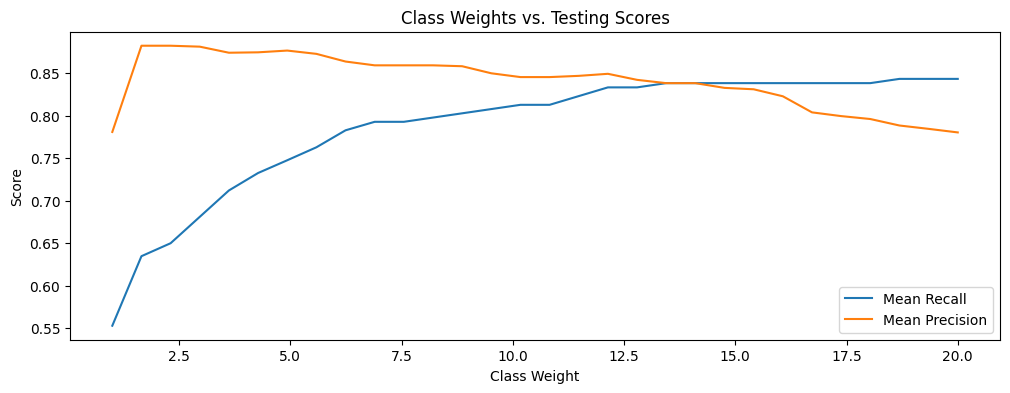

In [16]:
plt.figure(figsize=(12, 4))

for score in ['mean_test_recall_score', 'mean_test_precision']:
    plt.plot([_[1] for _ in cv_results_pr['param_class_weight']], cv_results_pr[score], label=score)

plt.title("Class Weights vs. Testing Scores")
plt.xlabel("Class Weight")
plt.ylabel("Score")

plt.legend(["Mean Recall", "Mean Precision"])

plt.show()

#### `Train` data

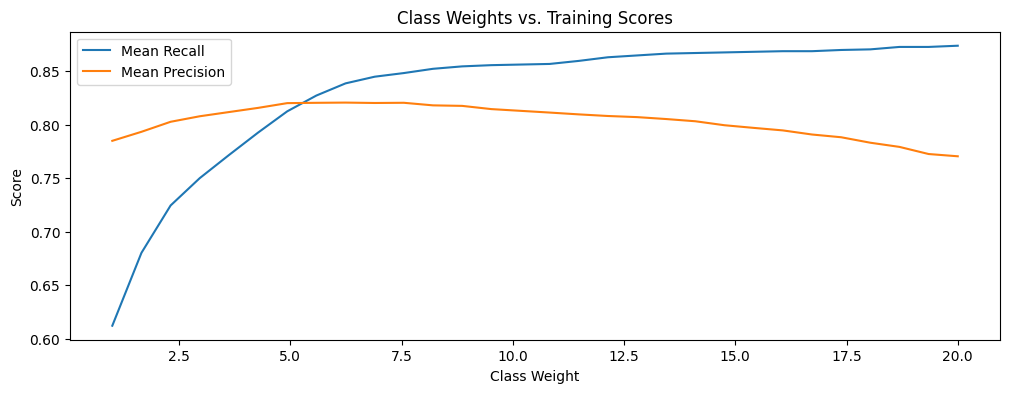

In [17]:
plt.figure(figsize=(12, 4))

for score in ['mean_train_recall_score', 'mean_train_precision']:
    plt.plot([_[1] for _ in cv_results_pr['param_class_weight']], cv_results_pr[score], label=score)

plt.title("Class Weights vs. Training Scores")
plt.xlabel("Class Weight")
plt.ylabel("Score")

plt.legend(["Mean Recall", "Mean Precision"])

plt.show()

### New performance metric
- We will create a new metric that optimizes on the `min()` of **precision** and **recall** scores

In [18]:
def min_precision_recall1(y_true, y_pred):
    p_score = precision_score(y_true, y_pred)
    r_score = recall_score(y_true, y_pred)
    
    return min(p_score, r_score)

### Creating and training the new **Grid**
- This makes use of the **new** metric
- Also, **transactions** are weighted by their `Amount`

In [20]:
grid_pr2 = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={'class_weight': [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]},
    scoring={"precision": make_scorer(precision_score), 
             "recall_score": make_scorer(recall_score),
             "min_recall_precision": make_scorer(min_precision_recall1)},
    refit='min_recall_precision',
    return_train_score=True,
    cv=10,
    n_jobs=-1)

grid_pr2.fit(X, y)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1.0},
                                          {0: 1, 1: 1.6551724137931034},
                                          {0: 1, 1: 2.310344827586207},
                                          {0: 1, 1: 2.9655172413793105},
                                          {0: 1, 1: 3.6206896551724137},
                                          {0: 1, 1: 4.275862068965517},
                                          {0: 1, 1: 4.931034482758621},
                                          {0: 1, 1: 5.586206896551724},
                                          {0: 1, 1: 6.241379310344827},
                                          {0: 1, 1: 6.896551724137931},...
                                          {0: 1, 1: 16.724137931034484},
                                          {0: 1, 1: 17.379310344827587},
                                          {0: 1, 1: 18.03448275862069},
                                          {0: 1, 1: 18.689655172413794},
                                          {0: 1, 1: 19.344827586206897},
                                          {0: 1, 1: 20.0}]},
             refit='min_recall_precision', return_train_score=True,
             scoring={'min_recall_precision': make_scorer(min_precision_recall1),
                      'precision': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)})

#### Results of the `cross-validation`

In [21]:
cv_results_pr2 = pd.DataFrame(grid_pr2.cv_results_)

cv_results_pr2.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,...,split2_train_min_recall_precision,split3_train_min_recall_precision,split4_train_min_recall_precision,split5_train_min_recall_precision,split6_train_min_recall_precision,split7_train_min_recall_precision,split8_train_min_recall_precision,split9_train_min_recall_precision,mean_train_min_recall_precision,std_train_min_recall_precision
0,1.142212,0.141055,0.022217,0.000895,"{0: 1, 1: 1.0}","{'class_weight': {0: 1, 1: 1.0}}",1.0,0.463415,0.583333,1.0,...,0.627119,0.548023,0.573864,0.573864,0.562500,0.613636,0.636364,0.607955,0.612185,0.054733
1,1.082443,0.110241,0.021911,0.000951,"{0: 1, 1: 1.6551724137931034}","{'class_weight': {0: 1, 1: 1.6551724137931034}}",1.0,0.463415,0.583333,1.0,...,0.683616,0.627119,0.670455,0.647727,0.630682,0.687500,0.698864,0.687500,0.680239,0.050286
2,1.034470,0.115824,0.021504,0.000390,"{0: 1, 1: 2.310344827586207}","{'class_weight': {0: 1, 1: 2.310344827586207}}",1.0,0.463415,0.583333,1.0,...,0.740113,0.683616,0.710227,0.698864,0.687500,0.715909,0.744318,0.727273,0.724454,0.043881
3,1.225997,0.308441,0.023132,0.003753,"{0: 1, 1: 2.9655172413793105}","{'class_weight': {0: 1, 1: 2.9655172413793105}}",1.0,0.452381,0.583333,1.0,...,0.785311,0.706215,0.744318,0.732955,0.715909,0.755682,0.772727,0.738636,0.749978,0.039589
4,0.963549,0.105964,0.021983,0.000984,"{0: 1, 1: 3.6206896551724137}","{'class_weight': {0: 1, 1: 3.6206896551724137}}",1.0,0.452381,0.583333,1.0,...,0.824859,0.740113,0.755682,0.744318,0.727273,0.778409,0.784091,0.761364,0.771498,0.037959


#### **Best** of the new `score`

In [22]:
cv_results_pr2.sort_values(by='mean_test_min_recall_precision', ascending=False).head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,...,split2_train_min_recall_precision,split3_train_min_recall_precision,split4_train_min_recall_precision,split5_train_min_recall_precision,split6_train_min_recall_precision,split7_train_min_recall_precision,split8_train_min_recall_precision,split9_train_min_recall_precision,mean_train_min_recall_precision,std_train_min_recall_precision
17,1.05457,0.115721,0.021781,0.000605,"{0: 1, 1: 12.137931034482758}","{'class_weight': {0: 1, 1: 12.137931034482758}}",0.857143,0.431818,0.576923,0.947368,...,0.828877,0.794737,0.801047,0.802139,0.787234,0.796875,0.794872,0.795812,0.807484,0.023328


### Plotting the performance metrics

#### **Without** the weighted `Amount`

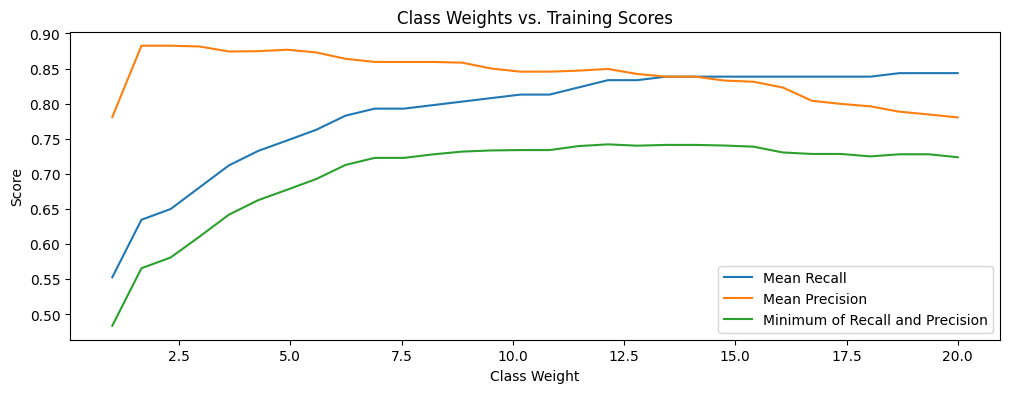

In [23]:
plt.figure(figsize=(12, 4))

for score in ['mean_test_recall_score', 'mean_test_precision', 'mean_test_min_recall_precision']:
    plt.plot([_[1] for _ in cv_results_pr2['param_class_weight']], cv_results_pr2[score], label=score)

plt.title("Class Weights vs. Training Scores")
plt.xlabel("Class Weight")
plt.ylabel("Score")

plt.legend(["Mean Recall", "Mean Precision", "Minimum of Recall and Precision"])

plt.show()

#### **With** the weighted `Amount`

In [24]:
def min_precision_recall2(est, X, y_true, sample_weight=None):
    y_pred = est.predict(X)
    p_score = precision_score(y_true, y_pred)
    r_score = recall_score(y_true, y_pred)
    
    return min(p_score, r_score)

grid_pr2_2 = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={'class_weight': [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]},
    scoring={"precision": make_scorer(precision_score), 
             "recall_score": make_scorer(recall_score),
             "min_recall_precision": min_precision_recall2},
    refit='min_recall_precision',
    return_train_score=True,
    cv=10,
    n_jobs=-1)

grid_pr2_2.fit(X, y, sample_weight=np.log(1 + df['Amount']))

cv_results_pr2_2 = pd.DataFrame(grid_pr2_2.cv_results_)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


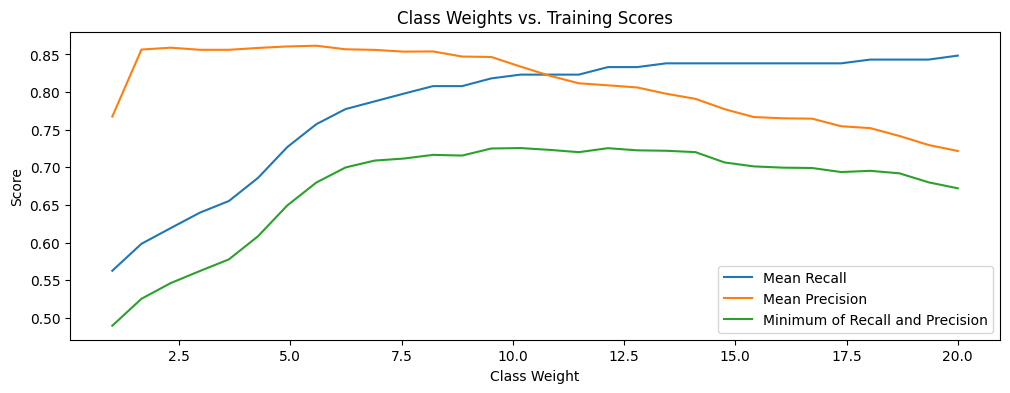

In [25]:
plt.figure(figsize=(12, 4))

for score in ['mean_test_recall_score', 'mean_test_precision', 'mean_test_min_recall_precision']:
    plt.plot([_[1] for _ in cv_results_pr2_2['param_class_weight']], cv_results_pr2_2[score], label=score)

plt.title("Class Weights vs. Training Scores")
plt.xlabel("Class Weight")
plt.ylabel("Score")

plt.legend(["Mean Recall", "Mean Precision", "Minimum of Recall and Precision"])

plt.show()

### Treating fraud cases as **outliers**
- Using the `IsolationForest` model

In [26]:
model2 = IsolationForest().fit(X)

print(f"Non-outliers\t: {Counter(np.where(model2.predict(X) == -1, 1, 0))[0]}\nOutliers\t: {Counter(np.where(model2.predict(X) == -1, 1, 0))[1]}")

Non-outliers	: 76922
Outliers	: 3078


### Defining a **grid** for `IsolationForest`
- New scoring metrics i.e. we treat **fraud** cases as **outliers**

In [27]:
def outlier_precision(mod, X, y):
    pred = mod.predict(X)
    return precision_score(y, np.where(pred==-1, 1, 0))

def outlier_recall(mod, X, y):
    pred = mod.predict(X)
    return recall_score(y, np.where(pred==-1, 1, 0))

grid_o = GridSearchCV(
    estimator=IsolationForest(),
    param_grid={
        'contamination': np.linspace(0.001, 0.02, 10)
    },
    scoring={
        'precision': outlier_precision,
        'recall': outlier_recall,
    },
    refit='precision',
    cv=5,
    n_jobs=-1
)

grid_o.fit(X, y)

GridSearchCV(cv=5, estimator=IsolationForest(), n_jobs=-1,
             param_grid={'contamination': array([0.001     , 0.00311111, 0.00522222, 0.00733333, 0.00944444,
       0.01155556, 0.01366667, 0.01577778, 0.01788889, 0.02      ])},
             refit='precision',
             scoring={'precision': <function outlier_precision at 0x7e588c8f1e10>,
                      'recall': <function outlier_recall at 0x7e588c8f15a0>})

#### Results of the `cross-validation`

In [28]:
cv_results_o = pd.DataFrame(grid_o.cv_results_)

cv_results_o.sort_values(by='mean_test_precision', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_contamination,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,...,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall
0,2.696328,0.070462,1.445379,0.018632,0.001,{'contamination': 0.001},0.553571,0.500000,0.714286,0.000000,...,0.297181,1,0.424658,0.034483,0.333333,0.000000,0.000000,0.158495,0.182774,10
1,2.638133,0.018355,1.421793,0.008020,0.003111,{'contamination': 0.003111111111111111},0.440476,0.325000,0.517857,0.035714,...,0.182551,2,0.506849,0.448276,0.644444,0.052632,0.166667,0.363774,0.220022,9
2,2.921487,0.238142,1.405230,0.013113,0.005222,{'contamination': 0.005222222222222222},0.314465,0.189189,0.380435,0.044444,...,0.123348,3,0.684932,0.482759,0.777778,0.105263,0.333333,0.476813,0.241894,8
3,2.777501,0.290847,1.383008,0.012519,0.007333,{'contamination': 0.007333333333333333},0.279412,0.147826,0.299065,0.037037,...,0.100148,4,0.780822,0.586207,0.711111,0.157895,0.400000,0.527207,0.225475,7
4,2.687328,0.058838,1.413086,0.023692,0.009444,{'contamination': 0.009444444444444443},0.265403,0.130081,0.248276,0.030928,...,0.093150,5,0.767123,0.551724,0.800000,0.157895,0.400000,0.535348,0.238671,6


### Plotting the performance metrics

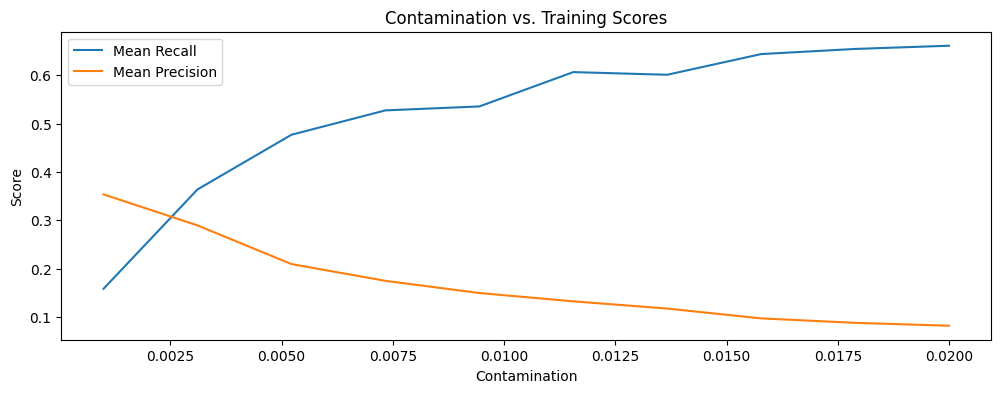

In [29]:
plt.figure(figsize=(12, 4))

for score in ['mean_test_recall', 'mean_test_precision']:
    plt.plot([_ for _ in cv_results_o['param_contamination']], cv_results_o[score], label=score)

plt.title("Contamination vs. Training Scores")
plt.xlabel("Contamination")
plt.ylabel("Score")

plt.legend(["Mean Recall", "Mean Precision"])

plt.show()

## Conclusion
Well, the `IsolationForest` model is of **no use**. We should stick to `Regression`.